Importing Libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from datetime import datetime
from pandas import DatetimeIndex, to_datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MeanShift
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
import pickle
import sys
from sys import exc_info

Loading Data

In [2]:
user_data = pd.read_csv("C:/Users/Godwin/Documents/Workflow/Clustering/movielen/ml-100k/u.data", names = ['user id', 'item id', 'rating', 'timestamp'], sep = '\s+')

movie_data = pd.read_csv("C:/Users/Godwin/Documents/Workflow/Clustering/movielen/ml-100k/u.item",  names = ["movie id", "movie title", "release date", "video release date",
              "IMDb URL", "unknown", "Action", "Adventure", "Animation", 
              "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", 
              "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", 
              "Thriller", "War", "Western"], sep = "|")

user_info = pd.read_csv("C:/Users/Godwin/Documents/Workflow/Clustering/movielen/ml-100k/u.user", names = ["user id", "age", "gender", "occupation", "zip code"], sep = '|')

In [3]:
#Viewing User Data
user_data.head()

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
#Viewing Movie Data
movie_data.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
#Viewing User Info
user_info.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Data Engineering

In [6]:
#User data engineering

user_data['timestamp'] = [datetime.utcfromtimestamp(i).strftime('%d/%m/%Y') for i in (user_data['timestamp'])]
user_data['timestamp'] = pd.to_datetime(user_data['timestamp'])

user_data['year'] = pd.DatetimeIndex(user_data['timestamp']).year
user_data['month'] = pd.DatetimeIndex(user_data['timestamp']).month
user_data['day'] = pd.DatetimeIndex(user_data['timestamp']).day
user_data.drop(['timestamp'], axis = 1, inplace = True)
user_data.head()

,user id,item id,rating,year,month,day
0,196,242,3,1997,4,12
1,186,302,3,1998,4,4
2,22,377,1,1997,7,11
3,244,51,2,1997,11,27
4,166,346,1,1998,2,2


In [7]:
#Checking for null values
user_data.isnull().sum()

user id    0
item id    0
rating     0
year       0
month      0
day        0
dtype: int64

In [8]:
#Movie Data Engineering
movie_data.drop(['video release date', 'release date', 'IMDb URL'], axis = 1, inplace = True)

movie_data['movie title'] = [i.split('(')[0] for i in movie_data['movie title']]

movie_data.rename(columns = {'movie id': 'item id'}, inplace = True)
movie_data.head()

,item id,movie title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
#Checking for null values
movie_data.isnull().sum()

item id        0
movie title    0
unknown        0
Action         0
Adventure      0
Animation      0
Children's     0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
dtype: int64

Merging Data

In [10]:
df = user_data.merge(user_info, on = 'user id')
data = movie_data.merge(df, on = 'item id')

Data Engineering

In [11]:
# Selecting datapoints where movies were rated by atleast 100 people
data = data.groupby(['item id'])
data = data.filter(lambda x: x['user id'].count() > 100)

# Selecting datapoints where rating is above 4
data = data[data['rating'] >= 4]

# Selecting the first 200 unique movies
item_list = np.unique(data['item id'])[:200]
data = data.loc[data['item id'].isin(item_list)]

#Selecting the first 500 unique users
first_500 = np.unique(data['user id'])[:500]
data = data.loc[data['user id'].isin(first_500)]

#Distinct Users
users = np.unique(data['user id'])

In [12]:
# Selecting Movies a user likes
def moviesListForUsers(users, users_data):
    # users = a list of users IDs
    # users_data = a dataframe of users favourite movies or users watched movies
    users_movies_list = []
    for user in users:
        users_movies_list.append(str(list(users_data[users_data['userId'] == user]['movieId'])).split('[')[1].split(']')[0])
    return users_movies_list

Data Encoding

In [13]:
le = LabelEncoder()

data['occupation'] = le.fit_transform(data['occupation'])
occupation_mapping = dict(zip(le.classes_, range(len(le.classes_))))

data['gender'] = le.fit_transform(data['gender'])
gender_mapping = dict(zip(le.classes_, range(len(le.classes_))))

#data['movie title'] = le.fit_transform(data['movie title'])
#title_mapping = dict(zip(le.classes_, range(len(le.classes_))))
data_copy = data.copy()

data.drop(['movie title', 'zip code', 'month', 'day','year', 'occupation', 'gender','rating'], axis = 1, inplace = True)

Fitting Model

In [17]:
model = MeanShift()
ms = model.fit(data)

cluster_centers = ms.cluster_centers_
n_clusters = len(cluster_centers)
labels = ms.labels_

In [18]:
print("Number of clusters detected by the algorithm:", n_clusters)
print("Cluster centers detected at:\n\n", cluster_centers)

Number of clusters detected by the algorithm: 2
Cluster centers detected at:

 [[1.78593894e+02 0.00000000e+00 3.26227135e-01 1.73707067e-01
  2.10554020e-02 4.26371891e-02 2.69245953e-01 1.10277668e-01
  3.02671404e-03 4.09527569e-01 2.36873273e-03 1.46071852e-02
  6.69824977e-02 5.42176602e-02 3.93472825e-02 2.29898671e-01
  2.11738387e-01 2.27398342e-01 1.38439268e-01 2.28977497e-02
  3.39587051e+02 3.24286090e+01]
 [1.81739673e+02 0.00000000e+00 3.42790335e-01 1.80826189e-01
  1.90179267e-02 3.85035074e-02 2.63133281e-01 1.03975058e-01
  1.24707716e-03 4.09197194e-01 1.09119252e-03 1.38737334e-02
  6.15744349e-02 5.01948558e-02 4.13094310e-02 2.29773967e-01
  2.28838659e-01 2.25409197e-01 1.37646142e-01 1.88620421e-02
  1.46842089e+02 3.37979735e+01]]


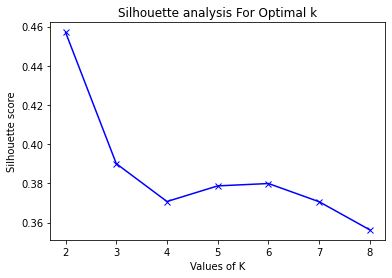

In [19]:
#Silhouette method for choosing number of clusters

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
      # initialise kmeans
      kmeans = KMeans(n_clusters=num_clusters)
      kmeans.fit(data)
      cluster_labels = kmeans.labels_
 
      # silhouette score
      silhouette_avg.append(silhouette_score(data, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

The Mean shift Clustering Model chose number of clusters which equals the heighest Silhouette Score